# Application Checkpointing

Pegasus provides support for transferring checkpoint files produced by a job. When a file(s) is designated as a checkpoint file for a job through the API, Pegasus will transfer that checkpoint file back to the staging site when the job completes or fails. Once the job is restarted, possibly on a different compute node, Pegasus will ensure that the saved checkpoint file is transferred to that compute node so that the job can resume from its most recent saved state.

This section of the tutorial will explain how checkpointing works in Pegasus and demonstrate to you how you can specify checkpoint files for your compute jobs. The tutorial is outlined as follows:

1. [Application Checkpointing at a High Level](#Application-Checkpointing-at-a-High-Level)
2. [What happens when a Pegasus job runs?](#What-Happens-When-a-Pegasus-Job-Runs)
3. [Specifying Checkpoint Files in the Workflow Generation Script](#Specifying-Checkpoint-Files-in-the-Workflow-Generation-Script)
4. [Checkpointing for Different Application Scenarios](#Checkpointing-for-Different-Application-Scenarios)
5. [Checkpointing Example Using Nonsharedfs](#Checkpointing-Example-Using-Nonsharedfs)

In [ ]:
import logging
import pickle
import os
import sys
import signal
import time
from datetime import datetime
from pathlib import Path
from multiprocessing import Process

from Pegasus.api import *

logging.basicConfig(level=logging.DEBUG)

## Application Checkpointing at a High Level

Checkpointing provides our applications with **fault tolerance**, a desirable property to have with long running applications performing expensive computations. The general idea is that an application should regularly save its state so that in the event of a failure, upon restart the application may continue where it left off. 

Below is an example of a simple counting program that employs checkpointing.

In [ ]:
# provided a checkpoint file to start with (assume this was created in a previous run)
with open("count.checkpoint", "w") as f:
    f.write("4")

In [ ]:
# number to count to
N = 10

# read from checkpoint file
current_count = 0
try:
    with open("count.checkpoint", "r") as f:
        current_count = int(f.read().strip())
except FileNotFoundError:
    pass

for i in range(current_count, N+1):
    print(i)
    
    # write checkpoint
    with open("count.checkpoint", "w") as f:
        f.write(str(i))
    
    time.sleep(1)

In [ ]:
# check checkpoint file is there
!ls -alh count.checkpoint

In [ ]:
# inspect the contents of the checkpoint file 
!cat count.checkpoint

## What Happens When a Pegasus Job Runs

Before going over how to use checkpointing in Pegasus, it is helpful to understand what happens under the hood when your jobs run. There are two components that we will take a look at: **pegasus-lite** and **pegasus-kickstart**.

### pegasus-lite

A pegasus job, when executed on some compute resource, is actually a simple workflow in itself consisting of 6-7 steps. These steps are run by a tool called **pegasus-lite** and each step is outlined here:
1. create a working directory
2. check for worker package (tools needed by Pegasus to run here)
3. download required input data for this job using **pegasus-transfer** or condorio file transfers
4. perform integrity checking on the data (has it been corrupted en route?)
5. launch the executable for this job (which you specified in the TransformationCatalog) using **pegasus-kickstart**
6. upload data produced by the job using **pegasus-transfer** or condorio file transfers (**checkpoint files are saved in this step**)
7. clean up (remove working directory and files downloaded and/or produced)

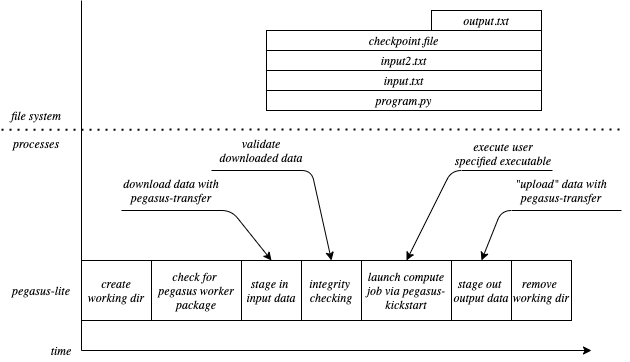

The figure above illustrates the execution timeline of pegasus-lite.

### pegasus-kickstart
When Pegasus runs your job's executable on your local machine or some remote host, it uses **[pegasus-kickstart](https://pegasus.isi.edu/documentation/manpages/pegasus-kickstart.html)** to do so. More specifically, pegasus-lite forks pegasus-kickstart, which then forks your executable. pegasus-kickstart is a wrapper program which manages and monitors the execution each job's executable while it is running. pegasus-kickstart is a command line tool, and so we can execute it just as we would any other CLI tool. 
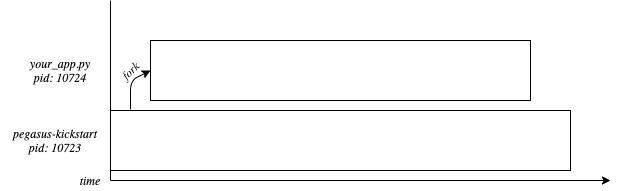

The figure above illustrates what happens when pegasus-kickstart is forked by pegasus-lite. 

In [ ]:
# using pegasus-kickstart as a standalone executable to invoke and monitor /bin/echo
!pegasus-kickstart echo hello world!

## Specifying Checkpoint Files in the Workflow Generation Script

In this section, we will see how you can designate one or more files produced by a job as checkpoint files so that Pegasus knows to save them for reuse. 

To designate a file as a checkpoint file for a job, simply use the function `Job.add_checkpoint(f: File)`. For example, say that you have created a `Pegasus.api.workflow.Job` object called `count_job`, which uses an executable that produces a checkpoint file called `count.checkpoint`. To inform Pegasus to save `count.checkpoint` as a checkpoint, you will need to invoke `count_job.add_checkpoint(File("count.checkpoint"))`. The following example workflow illustrates this usage. 

**Note**. When using the `condorio` data staging configuration, an initial checkpoint file must be provided (it must reside somewhere and be added to your ReplicaCatalog). When using the `nonsharedfs` data staging configuration, this is not required. The following examples assume a `condorio` data staging configuration is used. 

In [ ]:
# create an initial checkpoint file that will exist before running the workflow
with open("count.checkpoint", "w") as f:
    f.write("0")

# save the following snippet to a file which we will reference in the transformation catalog
# this is our executable to be used in the workflow
with open("count.py", "w") as f:
    f.write("""#!/usr/bin/env python3
import time
# number to count to
N = 5

current_count = 0

try:
    # read from checkpoint file
    with open("count.checkpoint", "r") as f:
        current_count = int(f.read().strip())
except FileNotFoundError:
    pass

checkpoint_count = current_count

for i in range(current_count, N+1):
    print(i)
    
    # purposely cause a failure so that we can see 
    # Pegasus checkpointing in action
    if i == 2 and checkpoint_count == 0:
        raise RuntimeError("failed on purpose")
    
    # write checkpoint
    with open("count.checkpoint", "w") as f:
        f.write(str(i))
    
    time.sleep(1)
    """)

In [ ]:
############################ START WORKFLOW SCRIPT ################################
# properties
props = Properties()
props["pegasus.mode"] = "production"
props.write()

# add starting checkpoint file to replica catalog
rc = ReplicaCatalog()
rc.add_replica(site="local", lfn="count.checkpoint", pfn=Path(".").parent.resolve() / "count.checkpoint")
rc.write()

# add executable 'count.py' to transformation catalog
tc = TransformationCatalog()
tc.add_transformations(
    Transformation(
        name="count.py",
        site="local",
        pfn=Path(".").parent.resolve() / "count.py",
        is_stageable=True
    )
)
tc.write()

# generate and run the workflow 
wf = Workflow("hello-checkpoint-tutorial")

# create the job and specify the checkpoint file 
count_job = Job("count.py")\
                .add_checkpoint(File("count.checkpoint"))\
                .set_stdout(File("count.out"))

wf.add_jobs(count_job)

wf.plan(submit=True).wait().statistics()
############################ END WORKFLOW SCRIPT ##################################

In [ ]:
!cat wf-output/count.checkpoint

In [ ]:
!cat wf-output/count.out

In [ ]:
rm -f wf-output/count* *.yml pegasus.properties

## Checkpointing for Different Application Scenarios

In this section, we address different application checkpointing scenarios and how to handle them, both in the context of your application and in Pegasus.

### Scenario: application periodically writes/overwrites large checkpoint file

With the counting application above, the checkpoint file write invocations are small and fast as shown in the figure below. In most cases, writing such checkpoint files will not be abdruptly interrupted such that the checkpoint file becomes corrupted. 

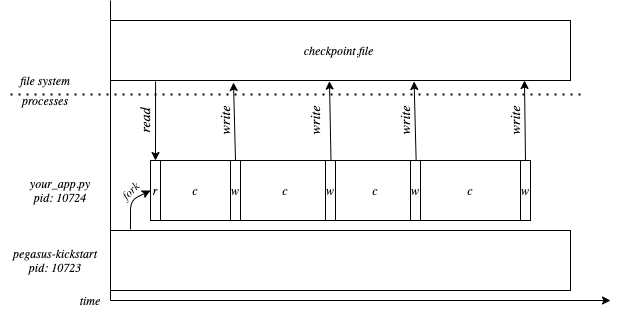

In some cases, the checkpoint file being written by an application may be large. In this scenario, we don't want to end up with a **corrupted** or **incomplete** checkpoint file as that will only crash the application when it tries to use it again upon restarting.

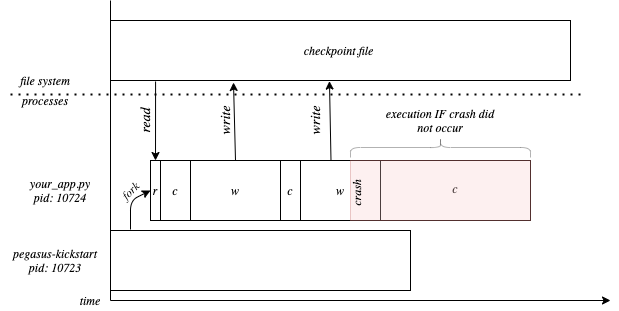

The snippet below illustrates what happens when an application is killed in the middle of writing a 1 GB checkpoint file, then tries to read it in again.

In [ ]:
# create a 1GB object in memory
s = "x"*(1<<30)
print("sizeof(s): {} MB".format(sys.getsizeof(s) // (1<<20)))

In [ ]:
# test how long it takes to write a 1GB string of characters to a file
start = time.time()
with open("big_file", "w") as f:
    f.write(s)
end = time.time()
duration = end - start
print("writing large file took: {} seconds".format(duration))

In [ ]:
# verify that we've written a very large file to disk 
!ls -alh big_file && rm -f big_file

In [ ]:
# do the same as above, but kill the process while it is writing to disk
def write_big_file():
    with open("big_file", "wb") as f:
        pickle.dump("x"*(1<<30), f)

p = Process(target=write_big_file)
p.start()
time.sleep(duration // 2)

# kill process mid write
os.kill(p.pid, signal.SIGKILL)
p.join()

In [ ]:
# verify size of large file < 1 GB
!ls -alh big_file

In [ ]:
# this won't work, as we expect
with open("big_file", "rb") as f:
    pickle.load(f)

In [ ]:
!rm -f big_file

Digging a little deeper, we can see that once we open a file in write mode, it is created (as shown by the open system call and the mask `O_CREAT` https://linux.die.net/man/3/open) and thus immediately visible on the filesystem. We will use strace to inspect the call to `open()`.

In [ ]:
!sudo yum install strace -y

In [ ]:
# send strace output to file test.file
!strace -Tfe trace=open -o tmp python3 -c 'open("test.file", "wb")'; ls -alh test.file

In [ ]:
# look for the open system call
! cat tmp | grep "test.file"; rm tmp test.file

### Solution: write to "temp" file, then rename once complete

This scenario can be handled by writing to a "temp" file, then renaming the "temp" file to have the name we originally intended. For example, if our application creates and uses a checkpoint file called `count.checkpoint`, then when writing the checkpoint file, writes should be done to `count.checkpoint.temp`, then immediately renamed to `count.checkpoint` after all the writes are complete. In Python `os.replace` is [atomic](https://docs.python.org/3/library/os.html#os.replace). In some cases, `mv` will be atomic as well (check your filesystem).

This is illustrated below.

In [ ]:
with open("count.checkpoint", "w") as f:
    f.write("4")

In [ ]:
# number to count to
N = 10

# read from checkpoint file
with open("count.checkpoint", "r") as f:
    current_count = int(f.read().strip())

for i in range(current_count, N+1):
    print(i)
    
    # write to temp file, then rename once write finishes
    with open("count.checkpoint.temp", "w") as f:
        f.write(str(i))
    
    # write finished, rename
    os.replace("count.checkpoint.temp", "count.checkpoint")
    
    time.sleep(1)

In [ ]:
# show that only count.checkpoint exists
!ls -alh | grep count.checkpoint*

In [ ]:
# check the contents of the checkpoint file
!cat count.checkpoint; rm -f count.checkpoint count.checkpoint.temp

### Scenario: we want Pegasus to "periodically" save a checkpoint file that is being updated while the job is running

Pegasus cannot asynchronously "save" (grab produced checkpoint file and send it back to the staging site where it can persist) checkpoint files throughout the lifespan of a a job. In other words, Pegasus can only save checkpoint files once the application fails or is killed by Pegasus. If a compute node suffers from a catastrophic failure (e.g. power outage), there is no way to send back any checkpoint files that may have been created. 

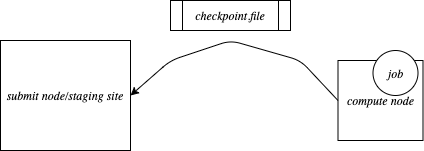

### Solution: intentionally kill the job after some period of time and restart it until it runs to completion

The solution to this is to have Pegasus intentionally kill the job after some period of time and then restart it, thus causing the designated checkpoint file(s) to be sent back to the staging site. Before going over how this can be done, we will briefly introduce signals. 

#### Brief Introduction to Signals

Unix operating systems provide you with the means to communicate with processes via signals. There are different types of signals, but the basic idea behind this is that each process can have signal handlers, and when that process receives a signal, it is interrupted and performs whatever code is in the designated handler (be careful! you can still be interrupted, with another signal while handling a current one..). There are two signals we will need to be aware of here.
- **SIGTERM**: "politely" interrupts program; can be handled, blocked, or ignored
- **SIGKILL**: causes immediate program termination

*source*: https://www.gnu.org/software/libc/manual/html_node/Termination-Signals.html

*source*: https://www.gnu.org/software/libc/manual/html_node/Signals-in-Handler.html#Signals-in-Handler 

For more information, see [this chapter on Event-based Concurrency](https://pages.cs.wisc.edu/~remzi/OSTEP/threads-events.pdf) in the OSTEP book. 

Lets see how our count program can be modified to handle a **SIGTERM** signal. 

In [ ]:
with open("count.checkpoint", "w") as f:
    f.write("4")

In [ ]:
def sample_job():
    # number to count to
    N = 10

    # read from checkpoint file
    with open("count.checkpoint", "r") as f:
        current_count = int(f.read().strip())

    # define signal handler 
    def SIGTERM_handler(signum, frame):
        # other code can be added here (set flags, etc.)
        print("got SIGTERM")

    # register SIGTERM_handler
    signal.signal(signal.SIGTERM, SIGTERM_handler)

    for i in range(current_count, N+1):
        print(i)

        # write to temp file, then rename once write finishes
        with open("count.checkpoint.temp", "w") as f:
            f.write(str(i))

        os.replace("count.checkpoint.temp", "count.checkpoint")
            
        time.sleep(1)

p = Process(target=sample_job)
p.start()
time.sleep(2)
os.kill(p.pid, signal.SIGTERM)
time.sleep(2)
os.kill(p.pid, signal.SIGKILL)

In [ ]:
!cat count.checkpoint

#### What does this look like in Pegasus

In the context of Pegasus jobs, the way that we can handle the above scenario is summarized as follows:
```
1.for i in NUM_RETRIES:
2.    let p = executable assigned to job
3.    p.start() asynchronously; break out if p is already done based on checkpoint file
4.    wait some period of time
5.    send_SIGTERM(p)
6.    wait some period of time <---  at this point p should prep the checkpoint file (rename, compress, etc.)
7.    send_SIGKILL(p)
```

In our workflow script, we will need to specify two profiles that correspond to steps 4-7 above:
- `Job.add_profiles(Namespace.PEGASUS, key="checkpoint.time", value=<minutes>)`
- `Job.add_profiles(Namespace.PEGASUS, key="maxwalltime", value=<minutes>)`

We will also need to set the NUM_RETRIES property. 
- `Job.add_profiles(Namespace.DAGMAN, key="retry", value=<NUM_RETRIES>)`
- this can also be done in the Properties object with `props["dagman.retry"]="<N>"` and it will be applied globally to all jobs

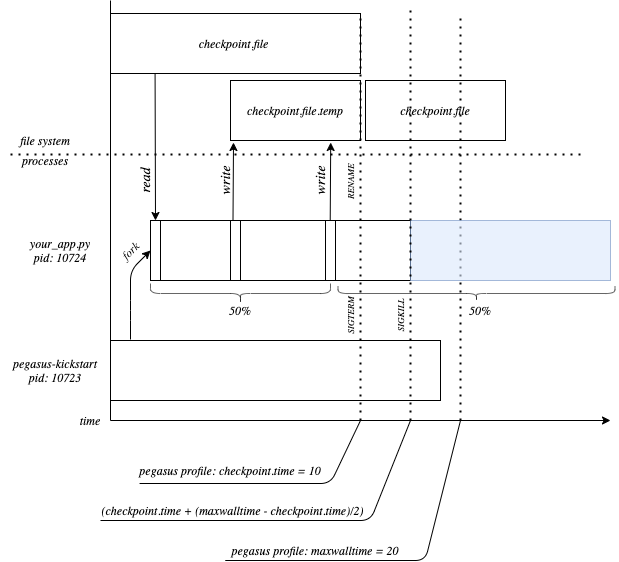

The figure above illustrates the execution timeline of your job starting with the invocation of pegasus-kickstart from pegasus-lite. At time `(checkpoint.time + (maxwalltime - checkpoint.time) / 2)` a `SIGKILL` will be sent to your running executable. At that point, a full checkpoint file should be written out so that pegasus-lite can transfer it back to the staging site. When the executable restarts, it can start from the state present in the checkpoint file and continue execution normally. 

In the following example, we will implement this periodic saving of checkpoint files as described above. While the workflow is running, the contents of the chechkpoint files saved at the staging site will be printed every time it updates to show that Pegasus is, in fact, periodically saving the checkpoint file produced by the job. 

In [ ]:
# cleanup any files produced from previous workflow runs
!rm -rf wf-output wf-scratch scitech *.yml pegasus.properties

# start from 0 
with open("count.checkpoint", "w") as f:
    f.write("0")

# save the following snippet to a file which we will reference in the transformation catalog
with open("count.py", "w") as f:
    f.write("""#!/usr/bin/env python3
import os
import time
import traceback
import signal

from pathlib import Path


# number to count to
N = 120

# read from checkpoint file
with open("count.checkpoint", "r") as f:
    current_count = int(f.read().strip())

# define signal handler
def SIGTERM_handler(signum, frame):
    # set any flags or final operations here as a SIGTERM will be sent soon
    print("got SIGTERM", flush=True)

# set the signal handler 
signal.signal(signal.SIGTERM, SIGTERM_handler)

for i in range(current_count, N+1):
    print(i, flush=True)

    # write to temp file, then rename once write finishes
    with open("count.checkpoint.temp", "w") as f:
        f.write(str(i))

    os.replace("count.checkpoint.temp", "count.checkpoint")

    time.sleep(1)
""")
    
############################ START WORKFLOW SCRIPT ################################
# add starting checkpoint file to replica catalog
rc = ReplicaCatalog()
rc.add_replica(site="local", lfn="count.checkpoint", pfn=Path(".").resolve() / "count.checkpoint")
rc.write()

# add executable 'count.py' to transformation catalog
tc = TransformationCatalog()
tc.add_transformations(
    Transformation(
        name="count.py",
        site="local",
        pfn=Path(".").resolve() / "count.py",
        is_stageable=True
    )
)
tc.write()

# generate and run the workflow 
wf = Workflow("hello-checkpoint-tutorial")

# create the job and specify the checkpoint file 
count_job = Job("count.py")\
                .add_checkpoint(File("count.checkpoint"))\
                .set_stdout("count.out")\
                .add_profiles(Namespace.PEGASUS, key="checkpoint.time", value=1)\
                .add_profiles(Namespace.PEGASUS, key="maxwalltime", value=2)\
                .add_profiles(Namespace.DAGMAN, key="retry", value=5)
    
wf.add_jobs(count_job)

wf.plan(force=True, submit=True)
############################ END WORKFLOW SCRIPT ##################################

def watch_output():
    """
    Prints the contents of the checkpoint file saved at the staging site whenever it changes.
    Prints the stdout of the job.
    """
    wf_scratch_dir = Path(".").resolve() / "wf-scratch/LOCAL/scitech/pegasus/hello-checkpoint-tutorial/run0001"
    checkpoint_file = wf_scratch_dir / "count.checkpoint"
    stdout_file = wf_scratch_dir / "count.out"
    
    checkpoint_file_ctime = 0
    stdout_file_ctime = 0
    
    while True:
        try:
            if checkpoint_file.stat().st_ctime > checkpoint_file_ctime:
                with checkpoint_file.open("r") as f:
                    print("\ncheckpoint.count -> {}: {}".format(datetime.now().isoformat(), f.read().strip()))
                
                checkpoint_file_ctime = checkpoint_file.stat().st_ctime
                
            if stdout_file.stat().st_ctime > stdout_file_ctime:
                with stdout_file.open("r") as f:
                    print("count.out -> {}".format(datetime.now().isoformat()))
                    print(f.read().strip())
                
                stdout_file_ctime = stdout_file.stat().st_ctime
                
        except FileNotFoundError:
            pass
    
        time.sleep(1)

watcher = Process(target=watch_output)
watcher.start()

wf.wait()
os.kill(watcher.pid, signal.SIGKILL)

### Things to Keep in Mind
- `maxwalltime` **must be greater than** `checkpoint.time`
- get an idea for how long it takes to write out your checkpoint file so that you can dial the above two parameters
- `dagman.retry` must be large enough to allow your job to complete

### Scenario: your application produces a variable number of checkpoint files, not known at the time you generate the workflow

In this scenario, your application produces a variable number of checkpoint files, all of which need to be saved. 

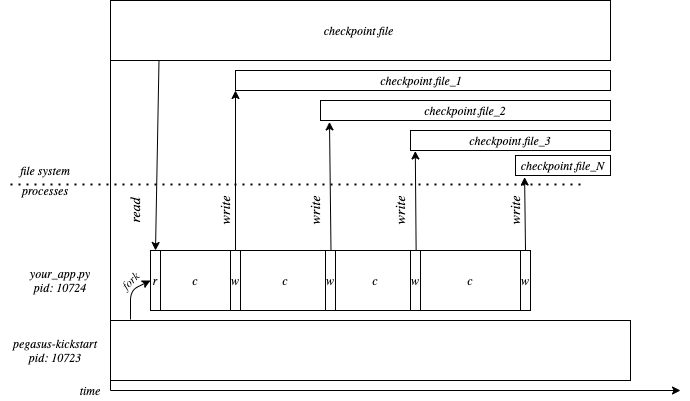


### Solution: using checkpoint.time and maxwalltime, update your job to compress / tar all the checkpoint files into a single one

To get around this, specify a single checkpoint file in your workflow script. Then, before your job exits, ensure there is code in there to `tar` up all the needed checkpoint files into a single checkpoint file, the one which you have designated in the workflow script. 

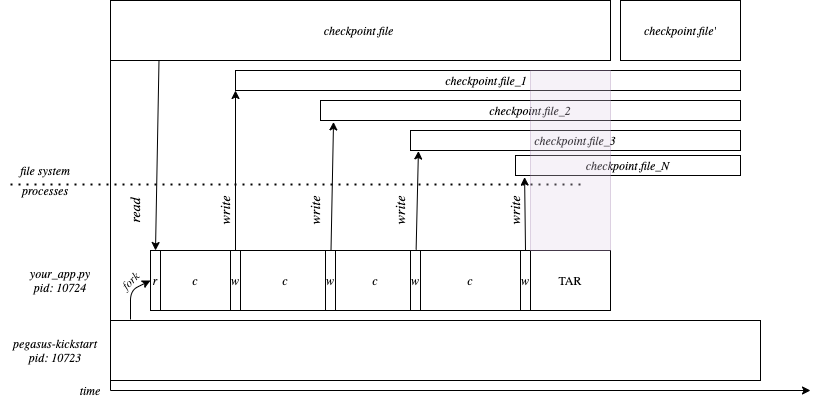

**caution**: compressing a large a mount of files takes time, and so you must give the application enough time to do this (set maxwalltime to be large enough)

## Checkpointing Example Using Nonsharedfs

The previous workflow examples all used the `condorio` data staging configuration. As such, an intial checkpoint file needed to be created and added to the replica catalog. The example below illustrates that this is not necessary when using the `nonsharedfs` data staging configuration. 

In [ ]:
# remove count.checkpoint if it exists
!rm -f count.checkpoint wf-output/count.checkpoint *.yml

In [ ]:
import logging

from pathlib import Path

from Pegasus.api import *

logging.basicConfig(level=logging.DEBUG)

# Set up properties
props = Properties()
props["pegasus.data.configuration"] = "nonsharedfs"
props["pegasus.mode"] = "development"
props.write()

# save the following snippet to a file which we will reference in the transformation catalog
with open("count.py", "w") as f:
    f.write("""#!/usr/bin/env python3
import time
# number to count to
N = 5

# read from checkpoint file
current_count = 0
try:
    with open("count.checkpoint", "r") as f:
        current_count = int(f.read().strip())
except FileNotFoundError:
    print("no checkpoint file, starting from the beginning")

for i in range(current_count, N+1):
    print(i)
    
    # write checkpoint
    with open("count.checkpoint", "w") as f:
        f.write(str(i))
    
    time.sleep(1)
    """)

# Create a Site Catalog for nonsharedfs data configuration
sc = SiteCatalog()


condorpool_site = Site("condorpool", arch=Arch.X86_64, os_type=OS.LINUX)\
                    .add_pegasus_profile(style="condor")\
                    .add_condor_profile(universe="vanilla")

staging_site = Site("stage", arch=Arch.X86_64, os_type=OS.LINUX)\
                .add_directories(
                    Directory(Directory.SHARED_SCRATCH, "/tmp/")
                        .add_file_servers(FileServer("file:///tmp/", Operation.ALL))
                )\
                .add_pegasus_profile(auxillary_local="true")

sc.add_sites(condorpool_site, staging_site)
sc.write()

# transformation catalog
tc = TransformationCatalog()\
        .add_transformations(
            Transformation(
                "count.py",
                site="local",
                pfn=Path(".").resolve() / "count.py",
                is_stageable=True
            )
        ).write()

# workflow 
wf = Workflow("test")
wf.add_jobs(Job("count.py").add_checkpoint(File("count.checkpoint")).set_stdout(File("out.txt")))

wf.plan(
    sites=["condorpool"],
    submit=True,
    staging_sites={"condorpool":"stage"}
).wait()

In [ ]:
# check the contents of our checkpoint file
!cat wf-output/count.checkpoint